# Homedeports en MEXICO


In [14]:
import requests
from sklearn.cluster import KMeans
from shapely.geometry import Polygon, Point

# Se crea la función que genera poligonos de cobertura a partir de coordenadas
def isolineGeneration(lat:float, lng: float, cov_type: str, value: float):
    
    coordinates = 'geo!' + str(lat) + ',' + str(lng)
    api_structure = 'https://isoline.route.ls.hereapi.com/routing/7.2/calculateisoline.json'
    payload = {
    		'apiKey' : 'A6oKk5QyLYkxJ4efaUoDQZjjRNQ2bibTpYA2SE0oxiM',
    		'start' : coordinates,
            'range': value,
            'rangetype':cov_type,
            'mode': 'shortest;car;traffic:disabled'
        }
    response=requests.get(api_structure, params=payload)
    response=response.json()
    polygon = response['response']['isoline'][0]['component'][0]['shape']
    
    listPoints = []
    for i in polygon:
        coors = i.split(",")
        listPoints.append([ float(coors[1]), float(coors[0])])
    
    return listPoints

In [15]:
# Función que determina si un punto está dentro de un polígono
def inside(polygon, lat: float, lng: float):
    
    # El poligono tiene puntos de lng,lat
    testPoint = Point(lng, lat)
    
    # Si el punto está en la cobertura no pasa nada, de lo contrario se borra
    if polygon.contains(testPoint):
        return True
    else:
        return False

In [16]:
import json
import pandas as pd
# Se leen los datos de clientes y de ubicaciones de Homecenter
clients = pd.read_csv('clients.csv', index_col = 'id').fillna(0).to_dict(orient = 'index')

with open('homecenters.json', 'r', encoding="utf8") as fp:
    homecenters = json.load(fp)

In [17]:
# Se crean los poligonos de cobertura a 15mins en carro y se verifican que clientes están dentro
for i in homecenters:
    homecenters[i]['polygon'] = isolineGeneration(homecenters[i]['lat'], homecenters[i]['lng'], 'time', 400)
    homecenters[i]['clients'] = []
    for j in clients:
        if inside(Polygon(homecenters[i]['polygon']), clients[j]['lat'], clients[j]['lng']):
            homecenters[i]['clients'].append(clients[j]) 

In [18]:
# Se crea un archivo json con los poligonos para graficarlos

jsonOut = {"type": "FeatureCollection", "name": "Homecenters Bogota", "features": []}

for i in homecenters:
    jsonOut['features'].append({"type": "Feature", 
                                "properties": {"name": i},
                                "geometry": {
                                    "type": "Polygon",
                                    "coordinates": [homecenters[i]['polygon']]
                                }})

with open('HC_Polygons.json', 'w') as fp:
    json.dump(jsonOut, fp)

# Resultados

Ahora se analizan los datos obtenidos.

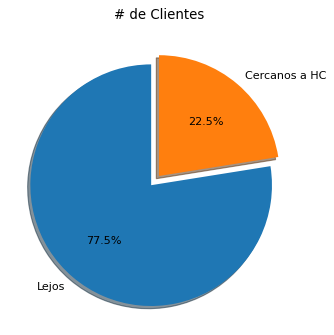

In [19]:
import matplotlib.pyplot as plt

# Número de clientes totales en el Universo y # de clientes cercanos a Homecenters
plt.figure(figsize=(14, 5), dpi=80)
labels = ['Lejos', 'Cercanos a HC']
sizes = [len(clients)-sum([len(homecenters[i]['clients']) for i in homecenters]), 
         sum([len(homecenters[i]['clients']) for i in homecenters])]
explode = (0.1, 0)

plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('# de Clientes')
plt.show()

Los Chillos - 37 - 51 - 374316.0239446089
San rafaek - 33 - 56 - 394280.27991516696
C.C. Quicentro Sur - 48 - 63 - 250936.34182909402
El recreo - 46 - 40 - 153064.52899111106
centro ferretero - 45 - 42 - 198274.36344413203
CC Olimpico - 35 - 26 - 56171.79473988699
Tumbaco - 29 - 14 - 16857.189163831
CC Mega Kywi - 22 - 48 - 515513.48837213585
Portal shopping - 1 - 0 - 0.0


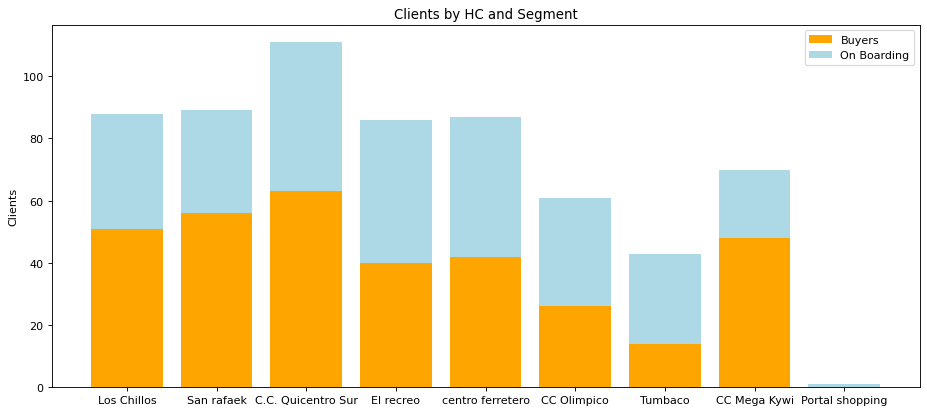

In [20]:
# Se calcula el numero de clientes para cada homecenter:
plt.figure(figsize=(14, 6), dpi=80)
y1, y2, y3, l = [],[],[],[]
for i in homecenters:
    noBuyers = 0
    Buyers = 0
    total = 0
    for j in homecenters[i]['clients']:
        total += j['acum_total']
        if j['acum_total'] == 0:
            noBuyers += 1
        else: Buyers += 1
    if (noBuyers+Buyers) >0:
        y1.append(noBuyers)
        y2.append(Buyers)
        y3.append(total)
        l.append(i)
    print(i, '-', noBuyers,'-', Buyers, '-',total)
plt.bar(l, y2, label = 'Buyers', color = 'orange')
plt.bar(l, y1, label = 'On Boarding', color = 'lightblue', bottom=y2)

plt.ylabel('Clients')
plt.title('Clients by HC and Segment')
plt.legend()

In [21]:
import pandas as pd

homC = pd.read_excel('homecentersXLS.xlsx', index_col = 'id').to_dict(orient='index')
print(homC)

{'Los Chillos': {'Direccion': 'Av. Gral. Rumiñahui 840,', 'lat': -0.3085112, 'lng': -78.4471447}, 'San rafaek': {'Direccion': 'San Rafael', 'lat': -0.3026051, 'lng': -78.4563011}, 'C.C. Quicentro Sur': {'Direccion': 'Av. Moran Valverde 1000', 'lat': -0.2849178, 'lng': -78.5433167}, 'El recreo': {'Direccion': 'Av. Pedro Vicente Maldonado S11-122', 'lat': -0.2533012, 'lng': -78.5229026}, 'centro ferretero': {'Direccion': 'Av. 10 de Agosto N24-59 y, Quito 170129, Ecuador', 'lat': -0.1990092, 'lng': -78.4968418}, 'CC Olimpico': {'Direccion': 'Av. 6 de Diciembre N52-72, Quito 170504, Ecuador', 'lat': -0.1743812, 'lng': -78.4791493}, 'Tumbaco': {'Direccion': 'Av. Oswaldo Guayasamin, Quito 170184, Ecuador', 'lat': -0.2157731, 'lng': -78.3954009}, 'CC Mega Kywi': {'Direccion': 'Centro Comercial Mega Kywi, Local 1, Av. Eloy Alfaro, Quito 170124, Ecuador', 'lat': -0.138585, 'lng': -78.4693875}, 'Portal shopping': {'Direccion': 'C.C. Portal Shopping, Av. Libertador, Quito 170209, Ecuador', 'lat':